###### In this notebook I attempt to fit my data using a neural network with the fastai library. I import my cleaned data, perform a train-test split, then build a simple model that takes advantage of transfer learning on an LSTM architecture.

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
sent_token = nltk.sent_tokenize
import csv  
from nltk import sent_tokenize, word_tokenize, pos_tag
import re
from sklearn.feature_extraction.text import CountVectorizer
wpt = nltk.WordPunctTokenizer()
from sklearn.model_selection import train_test_split
import random
from datetime import datetime
from fastai.text import *

file_path_comments = r'~/Documents/Springboard/Springboard/Data/cleaned_comment_data.csv'
#file_path_comments = r'/mnt/c/Users/msteele9/Documents/Springboard/Springboard/Data/cleaned_comment_data.csv'

clean_comments = pd.read_csv(file_path_comments, index_col = False)

In [2]:
X = clean_comments['commentBody']
y = clean_comments['recommendations']
print(X[1])
y.head(5)

Stunning photos and reportage. Infuriating that the Trump admistration's draconian reinstatement of the global gag order will prevent men and women from receiving appropriate family planning advice, so obviously desperately   needed.


0    2.0
1    1.0
2    3.0
3    7.0
4    5.0
Name: recommendations, dtype: float64

## In this next cell, I convert my integer target, 'recommendations', to a category target. I create bins such as (-1 to 1), (1 to 25) and so on, placing my recommendation values in the correct bin.

In [3]:
#set up bins
bin = [-1, 1, 25, 1000000]
label = [0, 1, 2]
#use pd.cut function can attribute the values into its specific bins
category = pd.cut(y, bin, labels=label)
category = category.to_frame()
category.columns = ['range']
#concatenate age and its bin
df_new = pd.concat([y,category],axis = 1)

### Here I create a crossfold validation split. I then merge the separated comments and recommendation counts into one dataframe containing training data and one dataframe containing test data, which fastai takes as inputs.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, df_new['range'], test_size=0.2, random_state=random.seed(datetime.now()))

In [26]:
df_nlp_data_train = pd.concat([y_train, X_train], axis=1)
df_nlp_data_test = pd.concat([y_test, X_test], axis=1)

path = r'~/Documents/Springboard/Springboard/Data/'
data_lm = TextLMDataBunch.from_df(path="", train_df=df_nlp_data_train, valid_df=df_nlp_data_test, bs=32)
data_clas  = TextClasDataBunch.from_df(path="", train_df=df_nlp_data_train, valid_df=df_nlp_data_test, bs=32)

In [27]:
#data_lm.show_batch(1)

### In this cell I am creating my model using data blocks created using the text classifier with the LSTM model architecture.

In [29]:
learn = language_model_learner(data_lm, AWD_LSTM)
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-2), moms=(0.8,0.7))
learn.save_encoder('enc')

epoch,train_loss,valid_loss,accuracy,time
0,3.996929,3.759622,0.344279,03:59


In [30]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.3)
learn.load_encoder('enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (40000 items)
x: TextList
xxbos xxmaj sotomayor believes she 's a better xxup scotus justice because she 's not male and not caucasian . xxmaj which means : xxmaj she intentionally discriminates against males and caucasians . xxmaj how is she a better xxup scotus justice than xxmaj gorsuch ?,xxbos xxmaj too bad it took cheating to get him in.<br / > xxmaj we can ignore xxmaj merrick xxmaj garland since a black pres nominated him ? xxmaj then we bend the rules to make sure our white knight gets in .,xxbos xxmaj rick xxmaj scott is only following precedent for a governor of xxmaj florida . xxmaj remember how xxmaj jeb xxmaj bush , the supposedly rational and sane candidate of last year 's field , shoved his big , meddling nose into the middle of a family 's private decision about end of life care for xxmaj terri xxmaj schiavo ? xxmaj when courts ruled against his executive order , he xxunk ordered the state xxmaj attorney xxmaj general

In [31]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-02
Min loss divided by 10: 6.92E-03


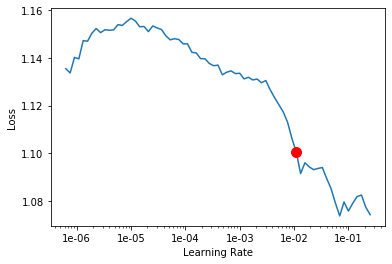

In [32]:
learn.recorder.plot(suggestion=True, skip_end=15)
min_grad_lr=learn.recorder.min_grad_lr

In [33]:
learn.fit_one_cycle(10, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.859919,0.860726,0.583900,01:48


In [34]:
learn.save('fit_head')

In [35]:
learn.load('fit_head');

In [36]:
learn.unfreeze()

In [37]:
#save_path = r'~/Documents/Springboard/Springboard/Models/'
#data_lm.save('~/Documents/Springboard/Springboard/Models/')

Here we get the predictions of the validation set, then print a sample of predictions. This is to verify that the model is not defaulting to a trivial output such as putting all predictions in the same category.

In [38]:
preds, y_predict, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y_predict)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.583899974822998 %.


Text(0.5, 1.0, 'Predictions')

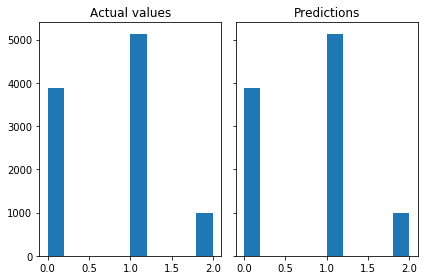

In [39]:
n_bins=10

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(y_test[:10000], bins=n_bins)
#axs[0].set_yscale('log')
axs[0].set_title('Actual values')
axs[1].hist(y_predict[:10000], bins=n_bins)
#axs[1].set_yscale('log')
axs[1].set_title('Predictions')

In [40]:
act_vs_pred = pd.concat([y_test[:10000].reset_index(), pd.Series(y_predict[:10000].numpy())], axis=1, ignore_index=True).drop(columns=[0])
print(act_vs_pred.head(10))

#print(act_vs_pred.groupby(1).count())
#print(act_vs_pred.groupby(2).count())
print(act_vs_pred[1].value_counts())
print(act_vs_pred[2].value_counts())

   1  2
0  1  1
1  1  1
2  1  1
3  2  1
4  2  1
5  1  0
6  1  0
7  1  0
8  1  0
9  0  0
1    5139
0    3875
2     986
Name: 1, dtype: int64
1    5139
0    3875
2     986
Name: 2, dtype: int64
